In [150]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import geoplot

In [151]:
#Load Data
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Classification_Fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)
#Select only the agricultural fires
fire_data = fire_data_classified

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')

#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month

#Select complete years (2015-2020)
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2015-01-01') & (geo_fire_data['acq_date'] < '2020-01-1')]

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [152]:
print('Amount of fires detected: ' + str(len(geo_fire_data)))

Amount of fires detected: 13142


In [153]:
geo_fire_data = geo_fire_data[geo_fire_data['agricultural']==1]
print('Amount of agricultural fires detected: '+ str(len(geo_fire_data)))

Amount of agricultural fires detected: 4249


<ipython-input-154-ae2b9fc67abb>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


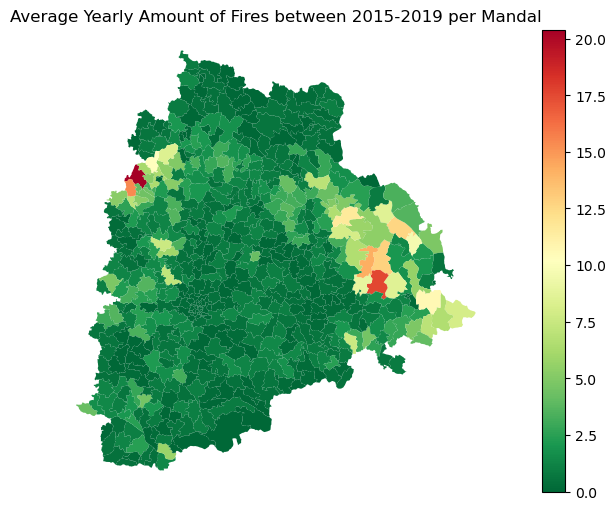

In [154]:
fires = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])
fires_count['Fire'] = 1

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam', 'year'])['Fire'].sum().unstack(fill_value=0).stack().reset_index()
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam'])[0].mean().reset_index()

mandal_boundaries = mandal_boundaries.reset_index()
fires_count = fires_count.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'geometry', 'index']], how='left', on=['Dist_Name', 'Mandal_Nam'])

indexes = fires_count['index'].to_list()

for i in range(0, len(mandal_boundaries)):
    if mandal_boundaries['index'].iloc[i] not in indexes:
        data = {'Dist_Name': mandal_boundaries['Dist_Name'].iloc[i], 'Mandal_Nam': mandal_boundaries['Mandal_Nam'].iloc[i], 0 : 0, 'geometry': mandal_boundaries['geometry'].iloc[i], 'index': mandal_boundaries['index'].iloc[i]}
        fires_count = fires_count.append(data, ignore_index=True)


fires_count = gpd.GeoDataFrame(fires_count,geometry = 'geometry', crs = {'init': 'epsg:4326'}) 

fires_count.plot(column = 0, legend = True, cmap = 'RdYlGn_r', figsize = (12, 6))
plt.title('Average Yearly Amount of Fires between 2015-2019 per Mandal')
plt.axis('off')
plt.show()

In [155]:
fires_count.sort_values(by=0, ascending = False)
#fires_count[0].mean()

,Dist_Name,Mandal_Nam,0,geometry,index
283,Nizamabad,Bodhan,20.4,"POLYGON ((77.94774 18.70379, 77.94776 18.70360...",68
31,Bhadradri Kothagudem,Yellandu,17.6,"POLYGON ((80.34248 17.78495, 80.39431 17.74970...",553
290,Nizamabad,Kotagiri,15.4,"POLYGON ((77.83827 18.62068, 77.83827 18.61972...",255
149,Mahabubabad,Gangaram,14.2,"POLYGON ((80.23231 18.02202, 80.24249 18.01442...",145
21,Bhadradri Kothagudem,Gundala,12.8,"POLYGON ((80.42952 18.05816, 80.43134 18.05733...",162
...,...,...,...,...,...
509,Wanaparthy,Gopalpet,0.0,"POLYGON ((78.16009 16.45245, 78.16027 16.45243...",157
508,Hyderabad,Golkonda,0.0,"POLYGON ((78.41919 17.39084, 78.41942 17.38589...",155
507,Karimnagar,Ganneruvaram,0.0,"POLYGON ((79.12616 18.39221, 79.12647 18.39110...",146
506,Rangareddy,Gandipet,0.0,"POLYGON ((78.31270 17.43188, 78.31535 17.43177...",143


<ipython-input-156-fb4de2e96d48>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


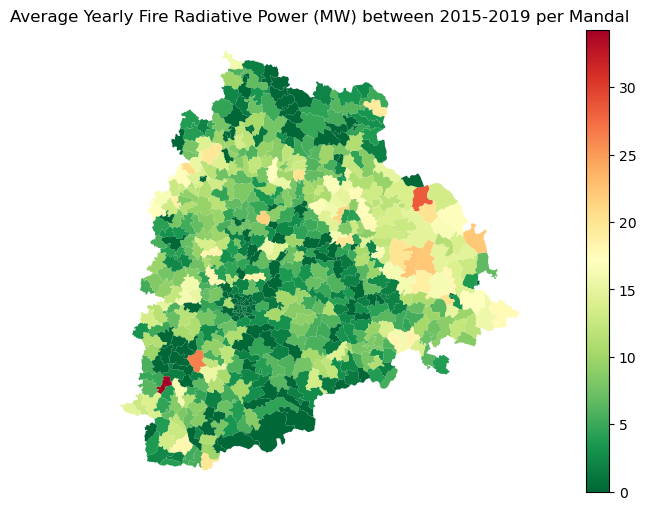

In [156]:

fires = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam', 'year'])['frp'].mean().unstack(fill_value=0).stack().reset_index()
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam'])[0].mean().reset_index()

fires_count = fires_count.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'geometry', 'index']], how='left', on=['Dist_Name', 'Mandal_Nam'])

indexes = fires_count['index'].to_list()

for i in range(0, len(mandal_boundaries)):
    if mandal_boundaries['index'].iloc[i] not in indexes:
        data = {'Dist_Name': mandal_boundaries['Dist_Name'].iloc[i], 'Mandal_Nam': mandal_boundaries['Mandal_Nam'].iloc[i], 0 : 0, 'geometry': mandal_boundaries['geometry'].iloc[i], 'index': mandal_boundaries['index'].iloc[i]}
        fires_count = fires_count.append(data, ignore_index=True)

fires_count = gpd.GeoDataFrame(fires_count,geometry = 'geometry', crs = {'init': 'epsg:4326'}) 

fires_count.plot(column = 0, legend = True, cmap = 'RdYlGn_r', figsize = (12, 6))
plt.title('Average Yearly Fire Radiative Power (MW) between 2015-2019 per Mandal')
plt.axis('off')
plt.show()

In [157]:
fires_count.sort_values(by=0, ascending = False).head(10)
#fires_count[0].mean()

,Dist_Name,Mandal_Nam,0,geometry,index
257,Narayanpet,Dhanwada,34.273333,"POLYGON ((77.69641 16.75135, 77.70094 16.75050...",115
209,Mulugu,Kannaigudem,28.380000,"POLYGON ((80.38763 18.59736, 80.39056 18.59276...",216
169,Mahabubnagar,Nawabpet,26.500000,"POLYGON ((78.03417 17.00886, 78.03423 17.00883...",376
149,Mahabubabad,Gangaram,22.458056,"POLYGON ((80.23231 18.02202, 80.24249 18.01442...",145
17,Bhadradri Kothagudem,Cherla,22.205714,"POLYGON ((80.83670 18.23886, 80.83707 18.23857...",84
21,Bhadradri Kothagudem,Gundala,22.155733,"POLYGON ((80.42952 18.05816, 80.43134 18.05733...",162
326,Rajanna Sircilla,Mustabad,21.550000,"POLYGON ((78.71965 18.36014, 78.72008 18.36001...",346
105,Karimnagar,Jammikunta,21.185000,"POLYGON ((79.56792 18.41966, 79.56795 18.41963...",194
300,Nizamabad,Renjal,20.798384,"POLYGON ((77.94333 18.82658, 77.94349 18.82643...",448
29,Bhadradri Kothagudem,Sujathanagar,20.470000,"POLYGON ((80.60094 17.54757, 80.60099 17.54699...",484


In [158]:
#Select one year
fire_data_2019 = fire_data[fire_data['year']==2019]
fires_agr_2019 = fires[fires['year']==2019]

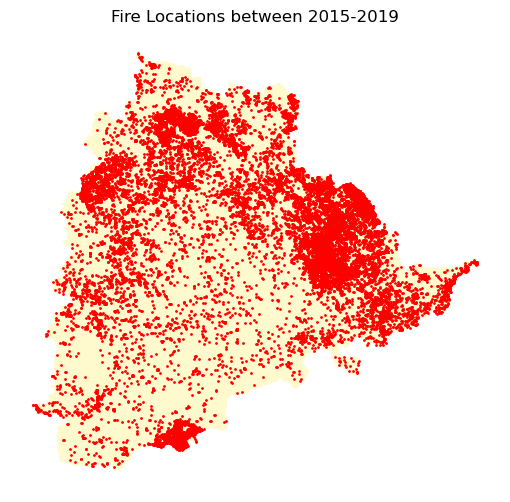

In [168]:
telangana_shape.plot(figsize = (12, 6), color='lemonchiffon')
plt.scatter(fire_data.longitude, fire_data.latitude, c='red', edgecolor = 'red', s=1)
plt.title('Fire Locations between 2015-2019')
plt.axis('off')
plt.show()

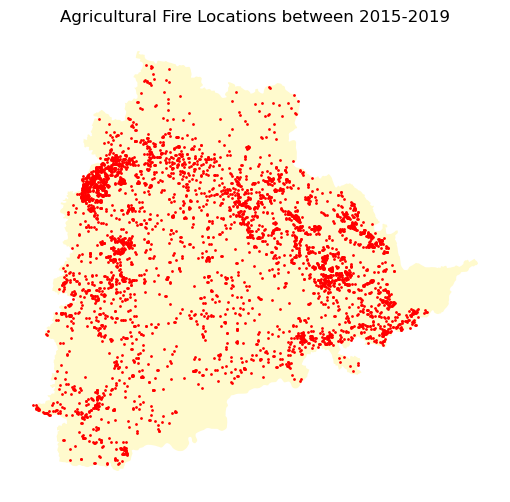

In [167]:
telangana_shape.plot(color = 'lemonchiffon', figsize = (12, 6))
plt.scatter(fires.longitude, fires.latitude, c='red', edgecolor = 'red', s=1)
plt.title('Agricultural Fire Locations between 2015-2019')
plt.axis('off')
plt.show()

<ipython-input-3-ca761372d940>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')


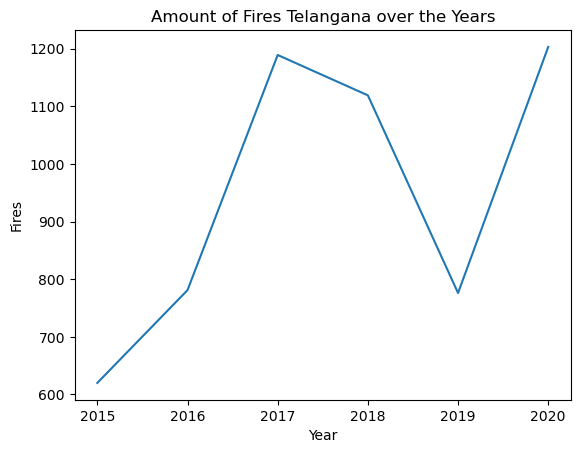

In [3]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['year'])['fireID'].count().reset_index()

plt.plot(fires_count['year'], fires_count['fireID'])
plt.title('Amount of Fires Telangana over the Years')
plt.xlabel('Year')
plt.ylabel('Fires')
plt.show()


<ipython-input-4-1a6dc2be2fca>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')


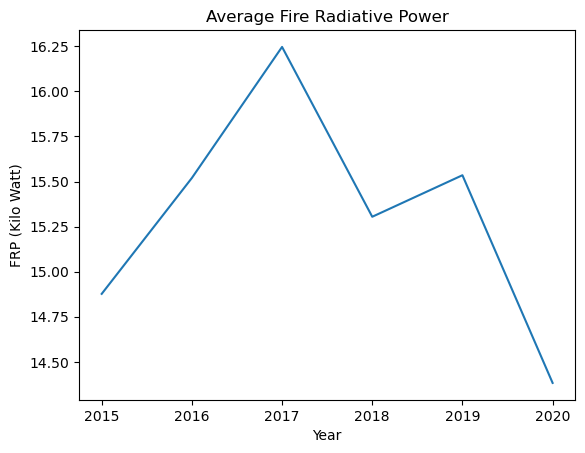

In [4]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['year'])['frp'].mean().reset_index()

plt.plot(fires_count['year'], fires_count['frp'])
plt.title('Average Fire Radiative Power')
plt.xlabel('Year')
plt.ylabel('FRP (Kilo Watt)')
plt.show()

In [20]:
fires_per_mandal = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'year',])['fireID'].count().unstack(fill_value=0).stack().reset_index()
fires_per_mandal_count['Fires'] = fires_per_mandal_count[0]
fig = px.line(fires_per_mandal_count, x="year", y='Fires', color='Mandal_Nam', title='Amount of Fires per Mandal in Telangana over the Years')
fig.show()
fig = px.bar(fires_per_mandal_count, x="year", y='Fires', color='Mandal_Nam', title='Amount of Fires per Mandal in Telangana over the Years', barmode='group')
fig.show()
total_fires = fires_per_mandal_count.groupby('Mandal_Nam')['Fires'].sum().reset_index()
total_fires = total_fires.sort_values(by='Fires', ascending = False)
fig = px.bar(total_fires, x='Mandal_Nam', y='Fires', title = 'Total Amount of Fires per Mandal')
fig.show()


<ipython-input-20-511acf62550c>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326




In [6]:
fires_per_mandal = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'year',])['frp'].mean().unstack(fill_value=0).stack().reset_index()
fires_per_mandal_count['Frp (Kilo Watts)'] = fires_per_mandal_count[0]
fig = px.line(fires_per_mandal_count, x="year", y = 'Frp (Kilo Watts)', color='Mandal_Nam', title='Average Fire Radiative Power per Mandal over the Years')
fig.show()

fig = px.bar(fires_per_mandal_count, x="year", y = 'Frp (Kilo Watts)', color='Mandal_Nam', title='Average Fire Radiative Power per Mandal over the Years', barmode='group')
fig.show()

<ipython-input-6-b7e64363caf0>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326


